In [5]:
from time import time
import unittest
import numpy as np
from sklearn.metrics import silhouette_score

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 

from keras.datasets import mnist
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util.util import *
from util import importNotebook
from module.autoencoder import VAE, ConvVAE

importing Jupyter notebook from ../module/autoencoder.ipynb


In [6]:
class TestVAE(unittest.TestCase):
    
    numEpochs = 10
    sizeBatch = 128
    sizeKernel = 3
    layerDense = [16, 2]
    ratRecon = 1
    nameOptim = 'adam'
    modelPath = '../model/temp/'
    patience = 3
    
    (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    xTrain = xTrain.astype('float32') / 255.
    xTest = xTest.astype('float32') / 255.
    numTrain = len(xTrain)
    numTest = len(xTest)
    sizeDigit = xTrain.shape[1:]

    dimInput = np.prod(xTrain.shape[1:])
    xTrain = xTrain.reshape((numTrain, dimInput))
    xTest = xTest.reshape((numTest, dimInput))
    print(xTrain.shape)
    print(xTest.shape)
    
    def test_init(self):
        vae = VAE(self.dimInput, layerDense=self.layerDense, ratRecon=self.ratRecon)
        vae.encoder.summary()
        vae.decoder.summary()
        vae.autoencoder.summary()
        self.vae = vae

    def test_fit(self):
        history, timeTrain = self.vae.fit(self.xTrain, self.xTest, 
                                          numEpochs=self.numEpochs,
                                          sizeBatch=self.sizeBatch,
                                          tempPathBest=self.modelPath)
    
    def testPrediction(self):
        # Set the initialization
        xTrain = self.xTrain
        xTest = self.xTest
        yTest = self.yTest
        sizeDigit = self.sizeDigit
        vae = self.vae
        encoder = vae.encoder
        decoder = vae.decoder
        
        # Get encoded and decoded values
        encodeTest = encoder.predict(xTest)
        decodeTest = decoder.predict(encodeTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
        err = compReconst(xTest, decodeTest)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
        scoreSilh = silhouette_score(encodeTest, yTest)    
        
        # Plot the decoding results from the encoding scatter
        plotScatterDecode(decoder, sizeDigit, xlim, ylim)

(60000, 784)
(10000, 784)


In [7]:
class TestConvVAE(unittest.TestCase):
    
    numEpochs = 10
    sizeBatch = 128
    sizeKernel = 3
    layerDense = [16, 2]
    layerConv = [4, 16]
    ratRecon = 1
    nameOptim = 'adam'
    modelPath = '../model/temp/'
    patience = 3
    
    (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    xTrain = xTrain.astype('float32') / 255.
    xTest = xTest.astype('float32') / 255.
    numTrain = len(xTrain)
    numTest = len(xTest)
    sizeDigit = xTrain.shape[1:]
    dimInput = [*xTrain.shape[1:], 1]
    xTrain = xTrain.reshape((numTrain, *dimInput))
    xTest = xTest.reshape((numTest, *dimInput))
    print(xTrain.shape)
    print(xTest.shape)
    
    def test_init(self):
        convVAE = ConvVAE(self.dimInput, layerDense=self.layerDense, layerConv=self.layerConv, ratRecon=self.ratRecon)
        convVAE.encoder.summary()
        convVAE.decoder.summary()
        convVAE.autoencoder.summary()
        self.convVAE = convVAE

    def test_fit(self):
        history, timeTrain = self.convVAE.fit(self.xTrain, self.xTest, 
                                              numEpochs=self.numEpochs,
                                              sizeBatch=self.sizeBatch,
                                              tempPathBest=self.modelPath)
        
    def testPrediction(self):
        # Set the initialization
        xTrain = self.xTrain
        xTest = self.xTest
        yTest = self.yTest
        sizeDigit = self.sizeDigit
        convVAE = self.convVAE
        encoder = convVAE.encoder
        decoder = convVAE.decoder
        
        # Get encoded and decoded values
        encodeTest = encoder.predict(xTest)
        decodeTest = decoder.predict(encodeTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
        err = compReconst(xTest, decodeTest)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
        scoreSilh = silhouette_score(encodeTest, yTest)  
        
        # Plot the decoding results from the encoding scatter
        plotScatterDecode(decoder, sizeDigit, xlim, ylim)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 16)           12560       input_3[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2)            34          dense_10[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2)            34          dense_10[0][0]                   
__________________________________________________________________________________________________
lambda_3 (

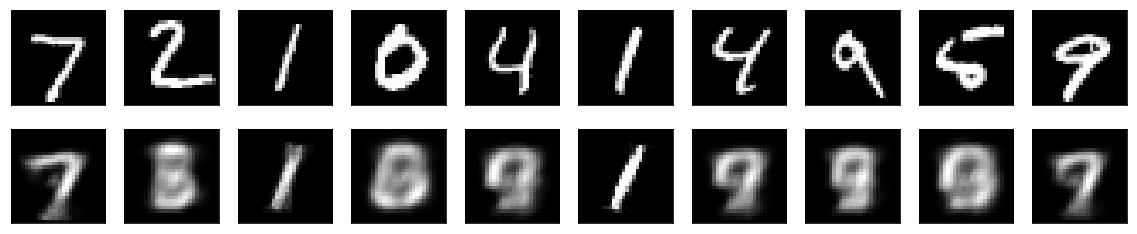

0.23192558


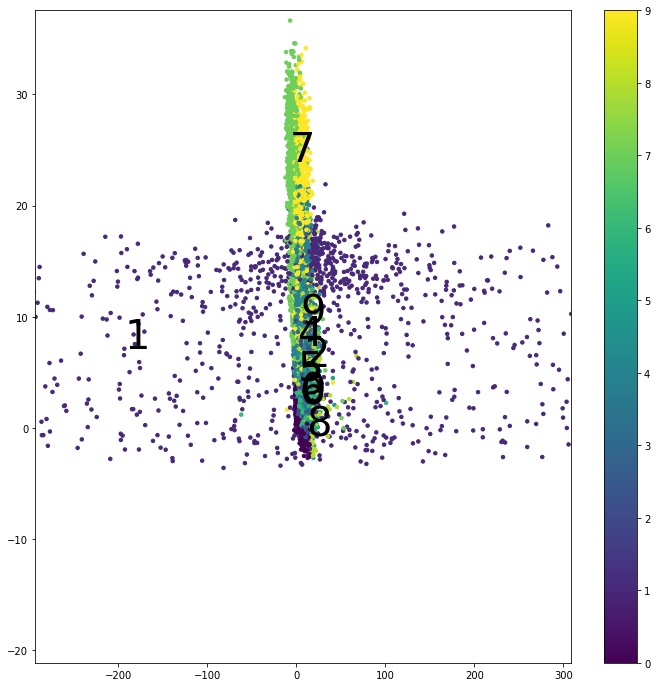

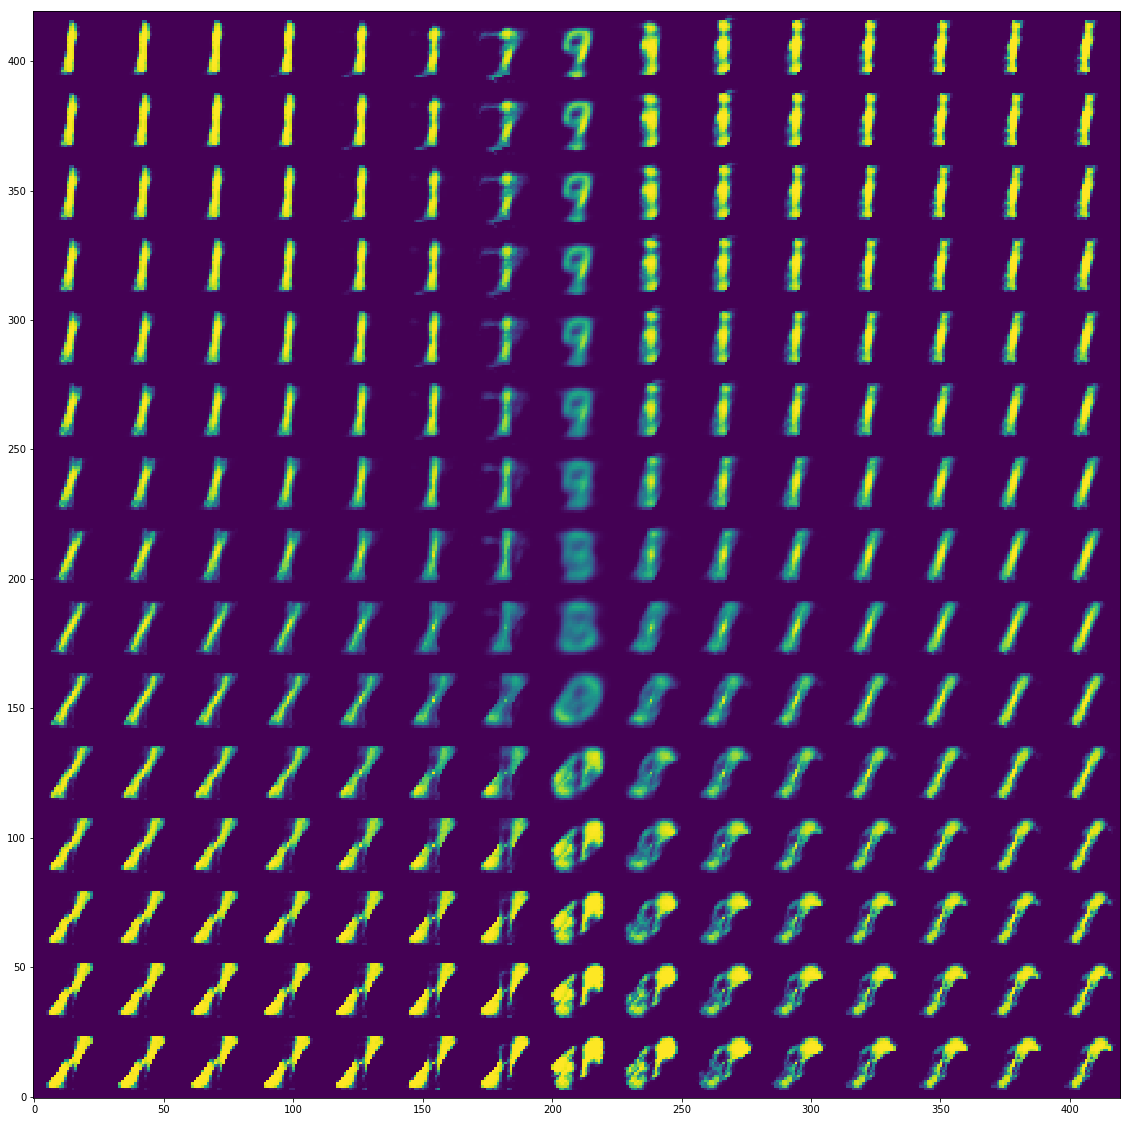

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 4)    40          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 7, 7, 16)     592         conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
dense_14 (

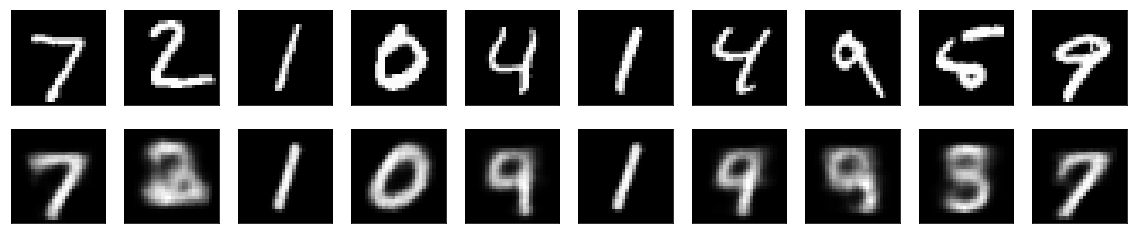

0.20970465


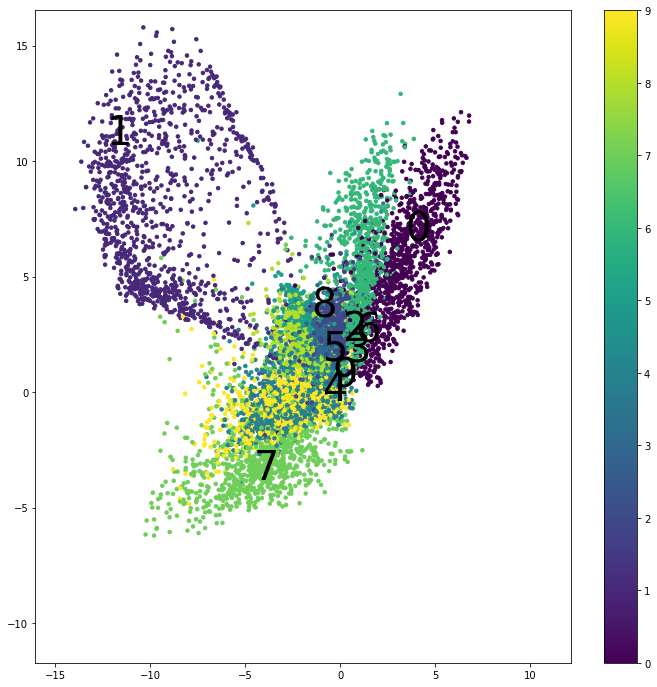

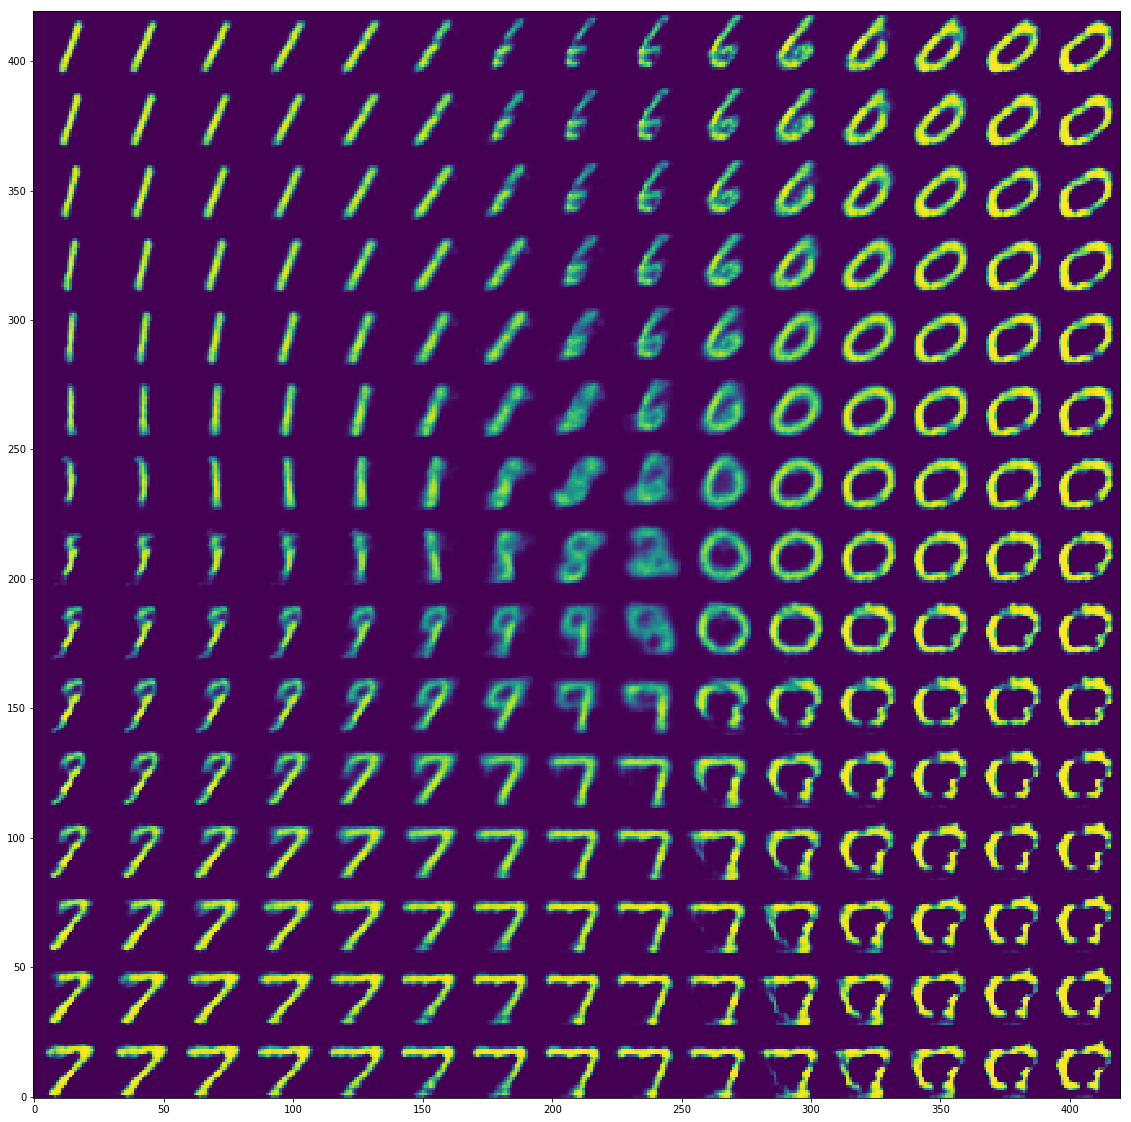

In [8]:
if __name__ == '__main__':
    testVAE = TestVAE()
    testVAE.test_init()
    testVAE.test_fit()
    testVAE.testPrediction()
    
    testConv = TestConvVAE()
    testConv.test_init()
    testConv.test_fit()
    testConv.testPrediction()